In [ ]:
import random
import numpy as np
import pandas as pd

In [ ]:
from Farm_Evaluator import getTurbLoc, loadPowerCurve, binWindResourceData, preProcessing, getAEP, checkConstraints

In [ ]:
power_curve   =  loadPowerCurve('power_curve.csv')
turb_rad = 50

In [ ]:
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)

In [ ]:
# Years on which the data is available
year_list = ['2009']

wind_data_list = []
for year in year_list:
    wind_data_list.append(pd.read_csv("wind_data_{}.csv".format(year)))

In [ ]:
# Problem parameter
min_lim = 50
max_lim = 3950
turb_count = 50
penalty = 0.02

In [ ]:
def gen_coord():
    x = round(random.uniform(min_lim, max_lim),2)
    y = round(random.uniform(min_lim, max_lim),2)
    return x,y

In [ ]:
def check_violation_old(turb1, turb2):
    return np.linalg.norm(turb1 - turb2) > 8*turb_rad

In [ ]:
from shapely import affinity
from shapely.geometry.point import Point

def create_ellipse(center, lengths, angle):
    circ = Point(center).buffer(1)
    ell = affinity.scale(circ, int(lengths[0]), int(lengths[1]))
    ellr = affinity.rotate(ell, angle)
    return ellr

major = 300
minor = 200
angle = 110

def check_violation(turb1, turb2):
    '''
    Return True if intersection is empty
    '''
    ellipse1 = create_ellipse(turb1, (major,minor), angle)
    ellipse2 = create_ellipse(turb2, (major,minor), angle)
    intersect = ellipse1.intersection(ellipse2)
    return intersect.is_empty

In [ ]:
def generate_turb_locations(count):
    arr = [gen_coord()]
    for i in range(count-1):
        while True:
            new_cord = gen_coord()

            if all([check_violation(np.array(cord), np.array(new_cord)) for cord in arr]):
                arr.append(new_cord)
                break
    return arr

In [ ]:
def calculate_AEP(turb_coords):
    aep = []
    for wind_data in wind_data_list:
        wind_inst_freq =  binWindResourceData(wind_data)
        aep.append(getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t))
    return sum(aep)/len(aep)

In [ ]:
# Cost functon for the problem
def cost_function(loc_flattened):
    turb_coords = loc_flattened.reshape(50,2)
    violation_count = count_violation(turb_coords)
    fitness = calculate_AEP(turb_coords)
    fitness -= fitness*penalty*violation_count
    return -fitness

In [ ]:
def count_violation(turb_coords):
    violation_count = 0
    for i,turb1 in enumerate(turb_coords):
        for turb2 in np.delete(turb_coords, i, axis=0):
            if  np.linalg.norm(turb1 - turb2) < 8*turb_rad:
                violation_count += 1
    return violation_count

In [ ]:
class Particle:
    def __init__(self,w=0.5,c1=2,c2=4):
        self.position_i = np.array(generate_turb_locations(turb_count)).flatten()          # particle position
        self.velocity_i = np.random.uniform(low=-1,high=1, size=(50*2))          # particle velocity
        self.pos_best_i = None         # best position individual
        self.err_best_i =-1          # best error individual
        self.err_i = -1               # error individual
        self.w = w
        self.c1 = c1
        self.c2 = c2
    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):     

        for i in range(0,num_dimensions):
            r1=np.random.random()
            r2=np.random.random()

            vel_cognitive=self.c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=self.c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=self.w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[1]:
                self.position_i[i]=bounds[1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[0]:
                self.position_i[i]=bounds[0]

In [ ]:
class PSO():
    def __init__(self,costFunc,bounds,params):
 
        self.err_best_g = -1                   # best error for group
        self.pos_best_g = None                 # best position for group
        self.bounds = bounds
        self.maxiter = params['maxiter']
        self.costFunc = costFunc

        # establish the swarm
        self.swarm=[]
        for i in range(params['num_particles']):
            self.swarm.append(Particle(w=params['w'],c1=params['c1'],c2=params['c2']))

    def run(self):
        # begin optimization loop
        self.pos_best_g_iterations = []
        i=0
        while i < self.maxiter:
            #print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for swarm in self.swarm:
                swarm.evaluate(self.costFunc)

                # determine if current particle is the best (globally)
                if swarm.err_i < self.err_best_g or self.err_best_g == -1:
                    self.pos_best_g = swarm.position_i
                    self.err_best_g = float(swarm.err_i)

            # cycle through swarm and update velocities and position
            for swarm in self.swarm:
                swarm.update_velocity(self.pos_best_g)
                swarm.update_position(self.bounds)
            i+=1
            self.pos_best_g_iterations.append(self.pos_best_g.reshape(50,2))
            print("Best fit in iteration no {}: {}".format(i, -self.err_best_g))
        
        # print final results
        print('FINAL:', -self.err_best_g)
        

In [ ]:
# Change the values here to tune the model
PSO_parameters = {'w': 0.5,# constant inertia weight (how much to weigh the previous velocity)
                  'c1': 2,# cognative constant
                  'c2': 4,# social constant
                  'num_particles': 20,
                  'maxiter': 25}

In [ ]:
global num_dimensions
num_dimensions= turb_count*2
bounds=[50,3950] 
model = PSO(cost_function,bounds,params = PSO_parameters)
model.run()

In [ ]:
checkConstraints(model.pos_best_g_iterations[-1],100)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = [ -cost_function(pos) for pos in model.pos_best_g_iterations]

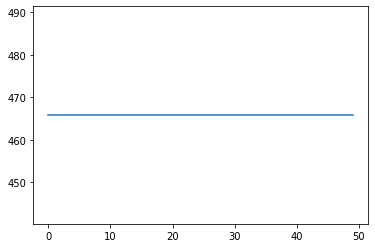

In [ ]:
plt.plot(data)

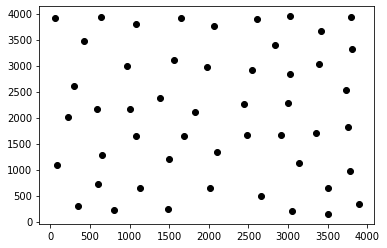

In [ ]:
turb_coords = model.pos_best_g_iterations[-1]
plt.scatter(turb_coords[:,0],turb_coords[:,1], c='black')

In [ ]:
import pandas as pd
loc=pd.DataFrame(model.pos_best_g_iterations[-1])
loc.to_csv('PSO_2.csv')